In [1]:
using FFTW
using Plots
using WAV
using DSP
#using PyPlot

## lowpasy i highpassy

In [21]:
function FIRfreqz(b::Array, w = LinRange(0, π, 1024))
    n = length(w)
    #h = Array{Complex{Float64},1}
    h=zeros(Complex{Float64},n)
    sw = 0
    for i = 1:n
      for j = 1:length(b)
        sw += b[j]*exp(-im*w[i])^-j
      end
      h[i] = sw
        #push!(h,sw)
      sw = 0
    end
    return h
end

FIRfreqz (generic function with 2 methods)

In [24]:
fs = 20
cutting_point=5 #hz
f = digitalfilter(Lowpass(cutting_point, fs = fs), FIRWindow(hamming(61)))
w = LinRange(0, pi, 1024)
h = FIRfreqz(f, w);

In [31]:
#h_db= log10 .*(abs.(h))
ws = w/pi*(fs/2);

┌ Warning: Attribute alias `zlabel` detected in the user recipe defined for the signature (::LinRange{Float64}, ::Array{Complex{Float64},1}). To ensure expected behavior it is recommended to use the default attribute `zguide`.
└ @ Plots C:\Users\Huawei\.julia\packages\Plots\SjqWU\src\pipeline.jl:26
┌ Warning: Attribute alias `ylabel` detected in the user recipe defined for the signature (::LinRange{Float64}, ::Array{Complex{Float64},1}). To ensure expected behavior it is recommended to use the default attribute `yguide`.
└ @ Plots C:\Users\Huawei\.julia\packages\Plots\SjqWU\src\pipeline.jl:26


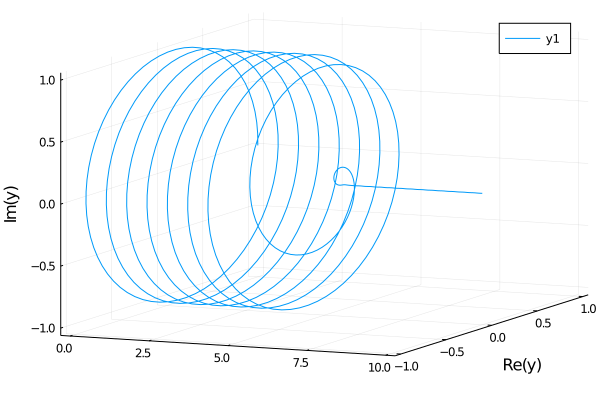

In [34]:
plot(ws,h) #ale zajebiste cacko XDD

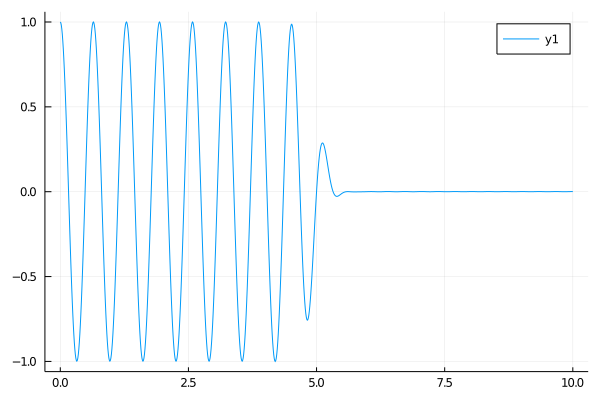

In [35]:
plot(ws,real.(h)) #lowpass działa

let's check on birds

In [36]:
brz,brz_fs=wavread("brzęczka.wav")
brz=brz[:,1];

In [38]:
cutting_point=5000 #hz
N=length(brz)
f = digitalfilter(Lowpass(cutting_point, fs = brz_fs), FIRWindow(hamming(N)))
w = LinRange(0, pi, 1024)
ha = FIRfreqz(f, w);

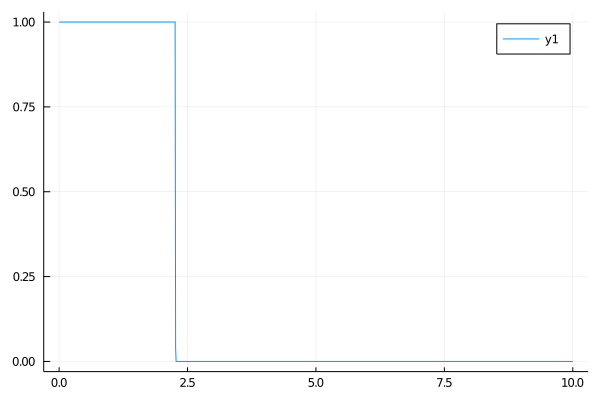

In [40]:
ws = w/pi*(fs/2);
plot(ws,abs.(ha))

low pass

In [157]:
x=0:30:1000
sin_noise(arr) = sin.(2π*50*arr) + randn(length(arr)) #juz blizej i sin_noise działa

sin_noise (generic function with 1 method)

In [162]:
designmethod = Butterworth(5)
ff= digitalfilter(Lowpass(0.02), designmethod);
y=filtfilt.(ff,sin_noise(x)) # ale nadal jakieś błędy xd

LoadError: [91mMethodError: no method matching length(::ZeroPoleGain{Complex{Float64},Complex{Float64},Float64})[39m
[91m[0mClosest candidates are:[39m
[91m[0m  length([91m::Cmd[39m) at process.jl:638[39m
[91m[0m  length([91m::DataStructures.IntSet[39m) at C:\Users\Huawei\.julia\packages\DataStructures\ixwFs\src\int_set.jl:191[39m
[91m[0m  length([91m::Plots.EmptyLayout[39m) at C:\Users\Huawei\.julia\packages\Plots\SjqWU\src\layouts.jl:210[39m
[91m[0m  ...[39m

## odszumianie pierwszym sposobem


In [6]:
function remove_frequency(sound, fs, N, freq_start, freq_stop)
    tstep = 1/fs
    t = LinRange(0, (N-1)*tstep, N)
    fstep = fs/N
    f = LinRange(0, (N-1)*fstep, N)
    
    fhat = fft(sound)
    fhat[floor(Int, freq_start * N/f[end]):ceil(Int, freq_stop * N/f[end])] .= 0
    fhat[floor(Int, (f[end] - freq_stop) * N/f[end]):ceil(Int, (f[end] - freq_start) * N/f[end])] .= 0

    fhat_mag = abs.(fhat)/N
    return fhat, fhat_mag, f
end

denoising (generic function with 1 method)

In [7]:
function denoising(sound, fs, N,cut_point) #wycina mniejsze wielkości
    tstep=1/fs
    time=LinRange(0, (N-1)/fs, N)
    freq_step = fs/N
    freq = LinRange(0, (N-1)*freq_step, N)
    
    fhat=fft(sound)
    PSD = real.(fhat .* conj(fhat)/N)
    #freq=1/(tstep*N)*[i for i in 1:N]
    
    indices=[i > cut_point for i in PSD]
    PSD_clean= indices .* PSD
    fhat_clean = indices .* fhat
    #filtred=ifft(fhat_clean)
    return time, PSD_clean, fhat_clean, freq
end
    

denoising (generic function with 1 method)

In [2]:
function denoising2(sound, fs, N,cut_point) #wycina wieksze wielkości
    tstep=1/fs
    time=LinRange(0, (N-1)/fs, N) #do poprawki
    
    fhat=fft(sound)
    PSD = real.(fhat .* conj(fhat)/N)
    freq=1/(tstep*N)*[i for i in 1:N]
    
    indices=[i < cut_point for i in PSD]
    PSD_clean= indices .* PSD
    fhat_clean = indices .* fhat
    filtred=ifft(fhat_clean)
    return time, PSD, freq, filtred
end
    

denoising2 (generic function with 1 method)

In [39]:
brzeczka, fs_b = wavread("brzęczka.wav")[1][:, 1], wavread("brzęczka.wav")[2]
N=length(brzeczka)
L=[i for i in 1:Int((N-1)/2)];

In [34]:
time,PSD,clear_brzeczka,freq=denoising(brzeczka,fs_b,N, 0.0005);
#freq_plot=freq[1:Int(N-1)/2+1]
#PSD_plot=PSD[1:Int(N-1)/2+1]

In [42]:
plot(freq[L], PSD[L], xlabel = "frequency", ylabel = "FFT/N",xlims=(0,2e4),ylims=(0,0.005));

In [9]:
plot(time,real.(clear_brzeczka));

In [131]:
N=length(brzeczka)
tstep=1/fs_b
brzeczka, fs_b = wavread("brzęczka.wav")[1][:, 1], wavread("brzęczka.wav")[2];
time=(N-1)/fs_b
T=0:tstep:time;

In [116]:
wavplay(real.(clear_brzeczka), fs_b)

In [113]:
#wavplay("clear_brzeczka.wav");

In [118]:
time2,PSD2,freq2,clear_brzeczka2=denoising2(brzeczka,fs_b,N, 0.0003);

In [137]:
plot(time2,real.(clear_brzeczka2),xlims=(0,0.05))
plot!(T,brzeczka,xlabel="time",ylabel="amplitude")


In [90]:
wavwrite(real.(clear_brzeczka2),"clear_brzeczka2.wav")

In [124]:
wavplay("brzęczka.wav")
wavplay(real.(clear_brzeczka2), fs_b)

jakies inne filtrowanie

In [51]:
plot(0:1/fs_b:(length(brzeczka)-1)/fs_b,brzeczka);

In [78]:
function plot_spectogram(s,fs)
    S=spectrogram(s, convert(Int, 20e-3*fs),
        convert(Int,10e-3*fs); window=hanning)
    t=time(S)
    f=freq(S)
    imshow(flipud(log10(power(S))), extent=[first(t), last(t), fs*first(f),
            fs*last(f)], aspect="auto")
    S
end

plot_spectogram (generic function with 1 method)

In [93]:
time[1:10:5]

1-element LinRange{Float32}:
 0.0

In [97]:
s=brzeczka
fs=fs_b
S=spectrogram(s, convert(Int,20e-3*fs),
        convert(Int,10e-3*fs); window=hanning);
t=length(S)
#f=freq(S)

LoadError: [91mMethodError: no method matching length(::DSP.Periodograms.Spectrogram{Float64,AbstractFFTs.Frequencies{Float64}})[39m
[91m[0mClosest candidates are:[39m
[91m[0m  length([91m::Cmd[39m) at process.jl:638[39m
[91m[0m  length([91m::DataStructures.IntSet[39m) at C:\Users\Huawei\.julia\packages\DataStructures\ixwFs\src\int_set.jl:191[39m
[91m[0m  length([91m::Plots.EmptyLayout[39m) at C:\Users\Huawei\.julia\packages\Plots\SjqWU\src\layouts.jl:210[39m
[91m[0m  ...[39m

In [98]:
sound1, fs_s = wavread("440Hz.wav")[1][:, 1], wavread("440Hz.wav")[2];

In [79]:
plot_spectogram(brzeczka,fs_b)

LoadError: [91mMethodError: objects of type LinRange{Float32} are not callable[39m
[91mUse square brackets [] for indexing an Array.[39m